<a href="https://colab.research.google.com/github/gb-lcro/poisson/blob/main/poisson_sin(pix)_sin(piy).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [78]:
import torch
import numpy as np
from numpy.ma.core import outer
from sys import stderr
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.pyplot import scatter, figure
from matplotlib.markers import MarkerStyle
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd

import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [79]:
batch_size = 32

In [80]:
def sample_dataset(start, end, num_samples, noise):
     x = torch.linspace(start, end, num_samples)
     y = torch.linspace(start, end, num_samples)
     X, Y = torch.meshgrid(x, y)

     sample_mean =  torch.sin(torch.pi * X) * torch.sin(torch.pi * Y)
     sample_var = noise*np.ones_like(sample_mean)
     u = stats.norm(sample_mean, sample_var).rvs(random_state=444)

     return x, y, X, Y, u, sample_mean

In [81]:
# Parameters for the training dataset
num_samples = 32
noise = 0.05
start = 0.0
end = 1.0

# Generate a dataset
x, y, X, Y, u, sample_mean = sample_dataset(start, end, num_samples, noise)

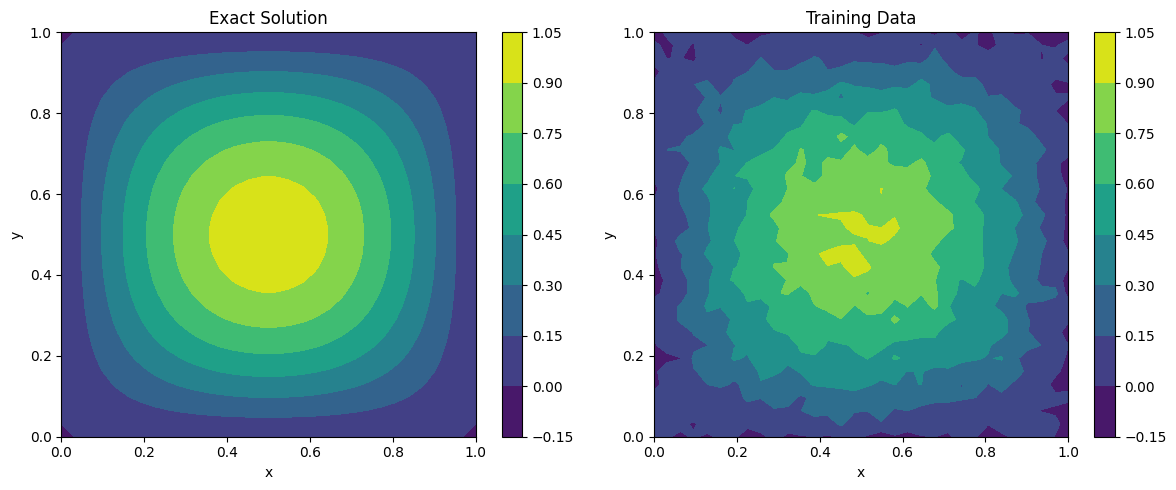

In [82]:
# Plot the solution and noisy data
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

contour_sol = axs[0].contourf(X, Y, sample_mean, cmap='viridis')
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
axs[0].set_title("Exact Solution")
fig.colorbar(contour_sol, ax=axs[0])

contour_u = axs[1].contourf(X, Y, u, cmap='viridis')
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
axs[1].set_title("Training Data")
fig.colorbar(contour_sol, ax=axs[1])
plt.tight_layout()
plt.show()

In [83]:
# Setup data and dataloader
xy_train = torch.stack((X.flatten(), Y.flatten()), dim=1)
u_train = torch.Tensor(u.flatten()).unsqueeze(1)

train_dataset = TensorDataset(xy_train, u_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [84]:
class FeedForward(nn.Module):

    def __init__(self):
        super(FeedForward, self).__init__()

        self.optimizer = None
        self.train_loss_history = []

        # weights for the total loss function
        self.w1 = 0.001  #loss_data
        self.w2 = 1      #loss_interior
        self.w3 = 5      #loss_bc

        # number of interior samples
        self.num_samples = 50

        self.hidden_size = 50

        # 2 input features
        self.b1 = nn.Linear(2, self.hidden_size)
        self.b2 = nn.Linear(self.hidden_size, self.hidden_size)
        self.b3 = nn.Linear(self.hidden_size, 1)

        # initialize weights
        nn.init.xavier_uniform_(self.b1.weight)
        nn.init.xavier_uniform_(self.b2.weight)
        nn.init.xavier_uniform_(self.b3.weight)


    def forward(self, x, y):

        xy = torch.stack((x, y), dim=1)

        h1 = torch.tanh(self.b1(xy))
        h2 = torch.tanh(self.b2(h1))
        u = self.b3(h2)

        return u

    def compute_derivative(self, u, x, n):
        # General formula to compute the n-th order derivative of u = f(x) with respect to x
        if n == 0:
            return u
        else:
            du_dx = torch.autograd.grad(u, x, torch.ones_like(u).to(device),
                                        create_graph=True, retain_graph=True,
                                        allow_unused=True)[0]

        return self.compute_derivative(du_dx, x, n - 1)

    def PDE_residual(self, x, y, use_meshgrid = False):
        if use_meshgrid:

            X,Y = torch.meshgrid(x,y)
            xy = torch.stack((X.flatten(), Y.flatten()), dim=1)

        x = torch.tensor(x, dtype=torch.float32).to(device)
        y = torch.tensor(y, dtype=torch.float32).to(device)
        x.requires_grad=True
        y.requires_grad=True

        u = self.forward(x, y)

        d2u_dx2 = self.compute_derivative(u, x, 2)
        d2u_dy2 = self.compute_derivative(u, y, 2)

        residual = d2u_dx2 + d2u_dy2 + 2*torch.pi**2 * torch.sin(torch.pi*x)*torch.sin(torch.pi*y)
        return residual



    def loss_data(self):
        input, output = next(iter(train_loader))
        x, y = input.T
        u = output

        x = torch.tensor(x, dtype=torch.float32).to(device)
        y = torch.tensor(y, dtype=torch.float32).to(device)
        u = torch.tensor(u, dtype=torch.float32).to(device)

        u_pred = self.forward(x, y)
        loss_data = torch.mean(torch.square(u - u_pred))
        return loss_data

    def loss_interior(self): #uniform sampling of x and y between [0,1] to pass to PDE_residual
        x_samples = torch.FloatTensor(self.num_samples, 1).uniform_(0, 1).flatten().to(device).requires_grad_(True)
        y_samples = torch.FloatTensor(self.num_samples, 1).uniform_(0, 1).flatten().to(device).requires_grad_(True)
        res = self.PDE_residual(x_samples, y_samples)
        loss_residual = torch.mean(torch.square(res)) #like rms error
        return loss_residual

    def loss_boundary_condition(self):
        self.x_top = torch.linspace(0, 1, 100).reshape(-1)
        self.y_top = torch.ones(1, 100).reshape(-1)

        self.x_bottom = torch.linspace(0, 1, 100).reshape(-1)
        self.y_bottom = torch.zeros(1, 100).reshape(-1)

        self.x_left = torch.zeros(1, 100).reshape(-1)
        self.y_left = torch.linspace(0, 1, 100).reshape(-1)

        self.x_right = torch.ones(1, 100).reshape(-1)
        self.y_right = torch.linspace(0, 1, 100).reshape(-1)

        bc_pred_top = self.forward(self.x_top.to(device), self.y_top.to(device))
        bc_pred_bottom = self.forward(self.x_bottom.to(device), self.y_bottom.to(device))
        bc_pred_left = self.forward(self.x_left.to(device), self.y_left.to(device))
        bc_pred_right = self.forward(self.x_right.to(device), self.y_right.to(device))


        loss_bc_top = torch.mean(torch.square(bc_pred_top))
        loss_bc_bottom = torch.mean(torch.square(bc_pred_bottom))
        loss_bc_left = torch.mean(torch.square(bc_pred_left))
        loss_bc_right = torch.mean(torch.square(bc_pred_right))

        loss_bc = loss_bc_top + loss_bc_bottom + loss_bc_left + loss_bc_right
        return loss_bc

    def compute_losses(self):
        loss_interior = self.loss_interior()
        loss_data = self.loss_data()
        loss_bc = self.loss_boundary_condition()
        return loss_interior, loss_data, loss_bc


    def closure(self):
        self.optimizer.zero_grad()
        loss_interior, loss_data, loss_bc = self.compute_losses()
        total_loss = self.w1 * loss_data + self.w2 * loss_interior + self.w3 * loss_bc
        total_loss.backward(retain_graph=True)
        return total_loss

    def get_training_history(self):
        loss_hist = np.array(self.train_loss_history)
        total_loss, loss_bc, loss_interior, loss_data = np.split(loss_hist, 4, axis=1)
        return total_loss, loss_bc, loss_interior, loss_data



    def plot_losses(self):
            total_loss, loss_interior, loss_data, loss_bc = self.get_training_history()

            plt.figure(figsize=(12, 8))

            plt.subplot(2, 2, 1)
            plt.plot(total_loss, marker=MarkerStyle('o', fillstyle='none'), color='black', label='Total Loss')
            plt.yscale('log')
            plt.legend()

            plt.subplot(2, 2, 2)
            plt.plot(loss_bc, marker=MarkerStyle('o', fillstyle='none'), color='red', alpha = 0.8, label='Boundary Condition Loss')
            plt.yscale('log')
            plt.legend()

            plt.subplot(2, 2, 3)
            plt.plot(loss_interior, marker=MarkerStyle('o', fillstyle='none'), color='blue', alpha = 0.2, label='Interior Loss')
            plt.yscale('log')
            plt.legend()

            plt.subplot(2, 2, 4)
            plt.plot(loss_data, marker=MarkerStyle('o', fillstyle='none'), color='green', alpha = 0.1, label='Data Loss')
            plt.yscale('log')
            plt.legend()

            plt.tight_layout()
            plt.show()

In [85]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model_poisson = FeedForward().to(device)
print(model_poisson)
print("Params:", sum(p.numel() for p in model_poisson.parameters() if p.requires_grad))

cuda:0
FeedForward(
  (b1): Linear(in_features=2, out_features=50, bias=True)
  (b2): Linear(in_features=50, out_features=50, bias=True)
  (b3): Linear(in_features=50, out_features=1, bias=True)
)
Params: 2751


In [90]:
def train(self, epochs, optimizer='Adam', **kwargs):
        if optimizer == 'Adam':
            self.optimizer = torch.optim.Adam(self.parameters(), **kwargs)

        elif optimizer == 'L-BFGS':
            self.optimizer = torch.optim.LBFGS(self.parameters(), **kwargs)

        # Training loop
        for epoch in range(epochs):
            self.optimizer.step(self.closure)

            # track progress and accumulate loss data for plotting
            if epoch % 2_000 == 0:
                loss_interior, loss_data, loss_bc = self.compute_losses()
                total_loss = loss_interior + loss_data + loss_bc

                self.train_loss_history.append([total_loss.cpu().detach().numpy(),
                                                loss_interior.cpu().detach().numpy(),
                                                loss_data.cpu().detach().numpy(),
                                                loss_bc.cpu().detach().numpy()
                                                ])

                print(f'Epoch ({optimizer}): {epoch}, Total Loss: {total_loss.detach().cpu().numpy()}')

In [91]:
train(model_poisson, 100_000, lr=1e-3)

Epoch (Adam): 0, Total Loss: 0.1705295741558075
Epoch (Adam): 2000, Total Loss: 0.0015497183194383979
Epoch (Adam): 4000, Total Loss: 0.01393270492553711
Epoch (Adam): 6000, Total Loss: 0.0020940029062330723
Epoch (Adam): 8000, Total Loss: 0.005277867428958416
Epoch (Adam): 10000, Total Loss: 0.007328050211071968
Epoch (Adam): 12000, Total Loss: 0.0021610697731375694
Epoch (Adam): 14000, Total Loss: 0.002300637774169445
Epoch (Adam): 16000, Total Loss: 0.0025027792435139418
Epoch (Adam): 18000, Total Loss: 0.004132504109293222
Epoch (Adam): 20000, Total Loss: 0.002417266136035323
Epoch (Adam): 22000, Total Loss: 0.004489506594836712
Epoch (Adam): 24000, Total Loss: 0.0021916383411735296
Epoch (Adam): 26000, Total Loss: 0.0062412372790277
Epoch (Adam): 28000, Total Loss: 0.003051135456189513
Epoch (Adam): 30000, Total Loss: 0.0023418329656124115
Epoch (Adam): 32000, Total Loss: 0.0050867036916315556
Epoch (Adam): 34000, Total Loss: 0.0031137317419052124
Epoch (Adam): 36000, Total Loss: 

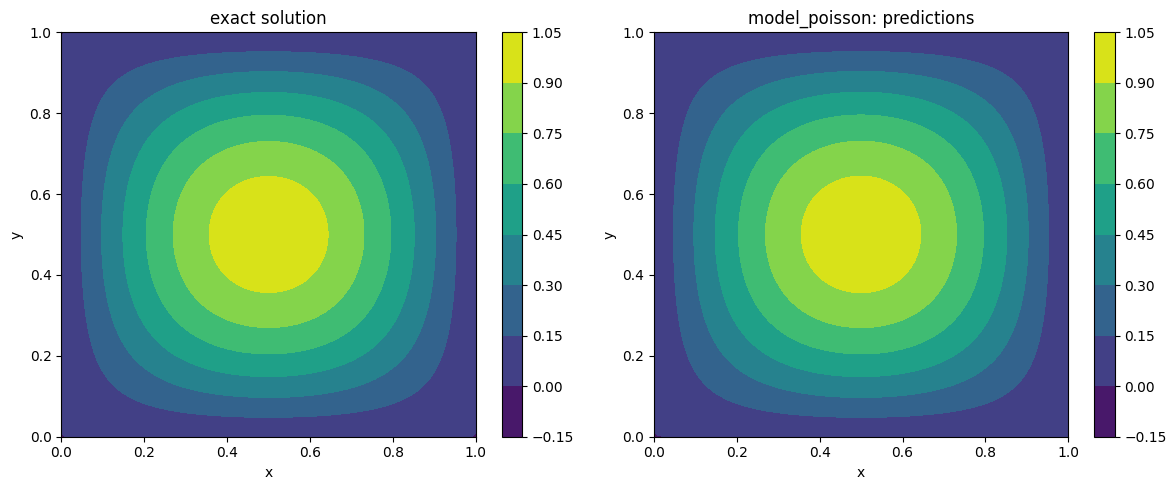

In [97]:
x_test, y_test, X_test, Y_test, u, sample_mean_test = sample_dataset(0.0, 1.0, 100, noise=0.0)
u_pred = model_poisson.forward(X_test.flatten().to(device), Y_test.flatten().to(device))
u_pred = u_pred.detach().cpu().numpy()
u_pred = u_pred.reshape(len(x_test), len(y_test))


fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot the solution and noisy data
contour_sol = axs[0].contourf(X_test, Y_test, sample_mean_test, cmap='viridis')
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
axs[0].set_title("exact solution")
fig.colorbar(contour_sol, ax=axs[0])

contour_u = axs[1].contourf(X_test, Y_test, u_pred, cmap='viridis')
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
axs[1].set_title("model_poisson: predictions")
fig.colorbar(contour_sol, ax=axs[1])
plt.tight_layout()
plt.show()

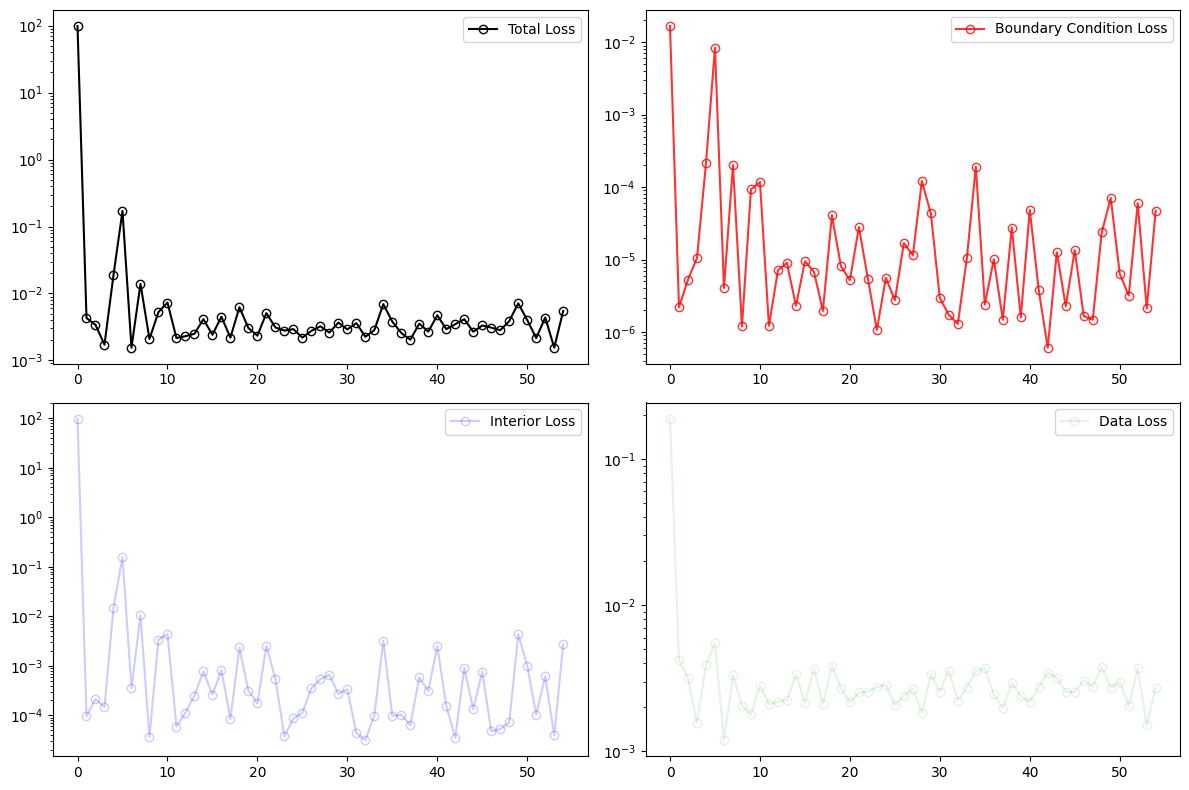

In [98]:
model_poisson.plot_losses()

In [94]:
##SAVE MODEL

from pathlib import Path
import torch

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "poisson_sinpix_sinpiy.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_poisson.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/poisson_sinpix_sinpiy.pth


In [95]:
# Check the saved file path
!ls -l models/poisson_sinpix_sinpiy.pth

-rw-r--r-- 1 root root 13716 Aug 29 16:40 models/poisson_sinpix_sinpiy.pth


In [101]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model_poisson = FeedForward()

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model_poisson.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
loaded_model_poisson.to(device)

FeedForward(
  (b1): Linear(in_features=2, out_features=50, bias=True)
  (b2): Linear(in_features=50, out_features=50, bias=True)
  (b3): Linear(in_features=50, out_features=1, bias=True)
)

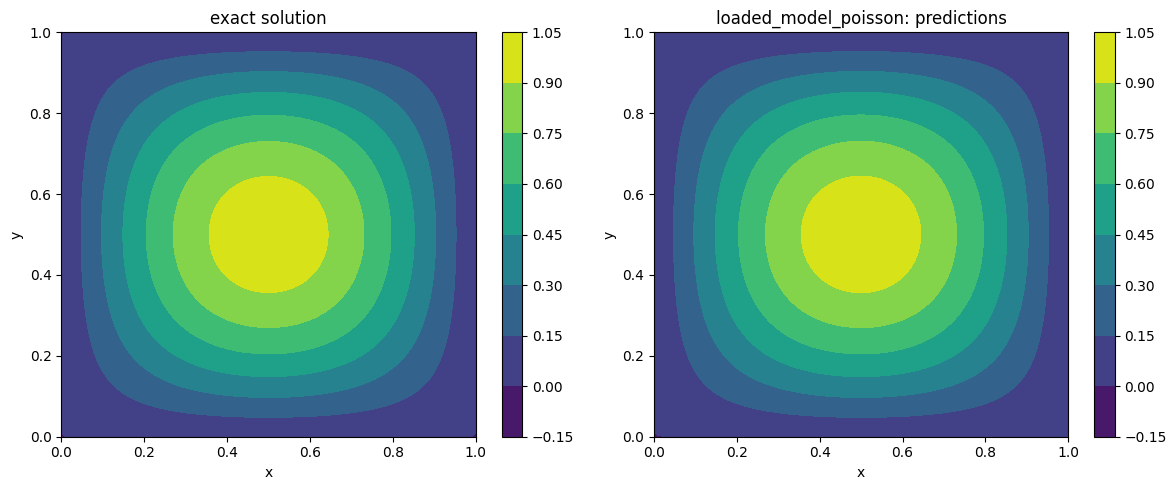

In [104]:
# 1. Put the loaded model into evaluation mode
loaded_model_poisson.eval()

# 2. Use the inference mode context manager to make predictions
with torch.inference_mode():  # perform a forward pass on the test data with the loaded model
    loaded_model_poisson_preds = loaded_model_poisson.forward(X_test.flatten().to(device), Y_test.flatten().to(device))

loaded_model_poisson_preds = loaded_model_poisson_preds.detach().cpu().numpy()
loaded_model_poisson_preds = loaded_model_poisson_preds.reshape(len(x_test), len(y_test))

# Plot the solution and predictions of loaded_model_poisson
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

contour_sol = axs[0].contourf(X_test, Y_test, sample_mean_test, cmap='viridis')
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
axs[0].set_title("exact solution")
fig.colorbar(contour_sol, ax=axs[0])

contour_u = axs[1].contourf(X_test, Y_test, loaded_model_poisson_preds, cmap='viridis')
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
axs[1].set_title("loaded_model_poisson: predictions")
fig.colorbar(contour_sol, ax=axs[1])
plt.tight_layout()
plt.show()

In [105]:
loaded_model_poisson_preds == u_pred

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [106]:
loaded_model_poisson_preds - u_pred

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)